In [1]:
import pandas as pd
import numpy as np
import io
import os

import matplotlib.pyplot as plt

import xgboost as xgb
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from pipeline import transform_events

from sklearn.metrics import classification_report
from sklearn.utils.fixes import loguniform
from scikitplot.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTENC

from scipy.stats import uniform, expon 
from function import add_on_target_prob

SEED = 42
np.random.seed(SEED)

from category_encoders import GLMMEncoder

/opt/anaconda3/envs/xGoals/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = transform_events()

Optimization terminated successfully.
         Current function value: 0.179663
         Iterations 10


In [24]:
X = df[['red_card_home_cum', 'red_card_away_cum', 'yellow_card_home_cum', 'yellow_card_away_cum',
        'attacks_home_cum', 'attacks_away_cum', 'dangerous_attacks_home_cum', 'dangerous_attacks_away_cum',
        'quarter', 'distance', 'angle','angle_over_distance', 'turnover_cum', 'header', 'penalty',#'shot', 
        'preceding_corner', 'preceding_freekick', 'preceding_other', 'preceding_save', 
        'preceding_blocked_shot', 'preceding_dangerous_attack', 'preceding_penalty', 
        'on_target_pred', 'goal_diff', 'goals_up_x_remaining', 'is_home', 'home_lead', 'away_lead',
        'is_in_penalty_area', 'is_in_goal_area', 'weather_condition', 'pitch_condition'
]]

y = df['goal']

In [4]:
# With GLMM encoding
X = df[['red_card_home_cum', 'red_card_away_cum', 'yellow_card_home_cum', 'yellow_card_away_cum',
        'attacks_home_cum', 'attacks_away_cum', 'dangerous_attacks_home_cum', 'dangerous_attacks_away_cum',
        'quarter', 'distance', 'angle','angle_over_distance', 'turnover_cum', 'type', 'prev_type',#'header', 'penalty',#'shot', 
        #'preceding_corner', 'preceding_freekick', 'preceding_other', 'preceding_save', 
        #'preceding_blocked_shot', 'preceding_dangerous_attack', 'preceding_penalty', 
        'on_target_pred', 'goal_diff', 'goals_up_x_remaining', 'is_home', 'home_lead', 'away_lead',
        'is_in_penalty_area', 'is_in_goal_area', 'weather_condition', 'pitch_condition'
]]

y = df['goal']

In [5]:
from category_encoders import GLMMEncoder

glmm_encoder = GLMMEncoder(cols=['type', 'prev_type'], binomial_target=False)
glmm_encoder.fit(X, y)
X = glmm_encoder.transform(X)

In [25]:
X.loc[X['header'] == 1, 'distance'] = X['distance']**2

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [27]:
# Post procsessing. Drop nans in train, set them to mean in test
drop_mask = ~(X_train['distance'].isna() | X_train['angle'].isna())
X_train, y_train = X_train[drop_mask], y_train[drop_mask]

X_test.loc[X['distance'].isna(), 'distance'] = X_test['distance'].mean()
X_test.loc[X['angle'].isna(), 'angle'] = X_test['angle'].mean()

In [118]:
# CV fit (don't run ~40min)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5],
    'gamma': [0, 1, 10],
    'reg_lambda': [0.5, 1, 5, 10],
    'scale_pos_weight': [0.15, 6.5], # Ratio between samples
    'subsample': [0.5, 1] 
}

cv = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, seed=SEED, verbose=0), 
    param_grid=param_grid, scoring='neg_log_loss', verbose=0
)
cv.fit(X_train, y_train)

In [121]:
cv.best_params_

{'gamma': 0,
 'learning_rate': 0.5,
 'max_depth': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 6.5,
 'subsample': 1}

In [32]:
X.columns

Index(['red_card_home_cum', 'red_card_away_cum', 'yellow_card_home_cum',
       'yellow_card_away_cum', 'attacks_home_cum', 'attacks_away_cum',
       'dangerous_attacks_home_cum', 'dangerous_attacks_away_cum', 'quarter',
       'distance', 'angle', 'angle_over_distance', 'turnover_cum', 'header',
       'penalty', 'preceding_corner', 'preceding_freekick', 'preceding_other',
       'preceding_save', 'preceding_blocked_shot',
       'preceding_dangerous_attack', 'preceding_penalty', 'on_target_pred',
       'goal_diff', 'goals_up_x_remaining', 'is_home', 'home_lead',
       'away_lead', 'is_in_penalty_area', 'is_in_goal_area',
       'weather_condition', 'pitch_condition'],
      dtype='object')

In [28]:
load_model = False
if load_model:
    cl = xgb.XGBClassifier()
    cl.load_model('model.txt')
else:
    best_params = {
        'gamma': 0,
        'learning_rate': 0.5,
        'max_depth': 5,
        'reg_lambda': 5,
        'scale_pos_weight': 6.5,
        'subsample': 1
    }
    cl = xgb.XGBClassifier(param_grid=best_params, use_label_encoder=False, seed=SEED, verbose=0)
    cl.fit(X_train, y_train)
    cl.save_model('model.txt')


/opt/anaconda3/envs/xGoals/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:34:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "param_grid", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:34:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
import eli5
eli5.explain_weights(cl, feature_names=list(X_train.columns))

Weight,Feature
0.2872,header
0.1744,is_in_penalty_area
0.1451,penalty
0.0470,is_home
0.0395,on_target_pred
0.0275,distance
0.0256,goal_diff
0.0218,goals_up_x_remaining
0.0180,preceding_other
0.0169,angle_over_distance


In [30]:
y_pred = cl.predict(X_test)
(y_pred == y_test).mean()

0.9097488292890592

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

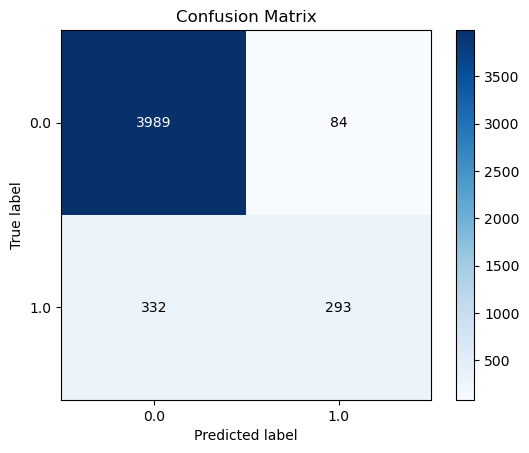

In [12]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Automl -> gives same results

from supervised.automl import AutoML
automl = AutoML(mode='Perform')
automl.fit(X_train, y_train)

In [ ]:
(automl.predict(X_test) == y_test).mean()

In [128]:
from sklearn.metrics import mean_absolute_error


mean_absolute_error(y_pred, y_test)

0.08641975308641975

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

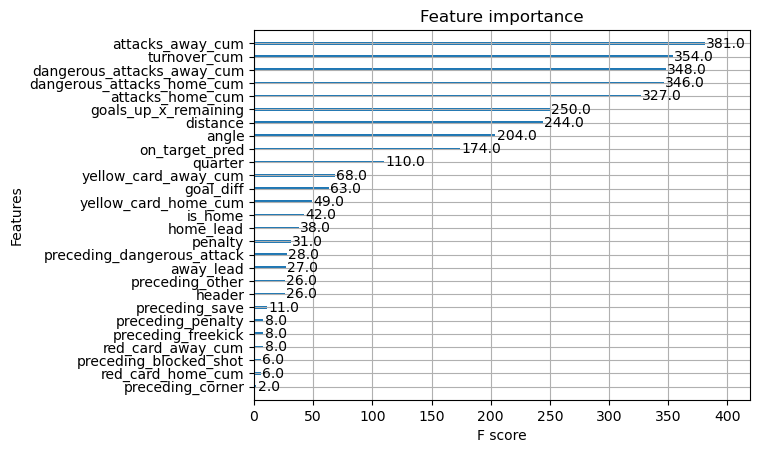

In [129]:
xgb.plot_importance(cl)

In [130]:
logit = LogisticRegression(max_iter=5000, penalty='l2', random_state=SEED)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

In [131]:
(y_pred == y_test).mean()

0.9003831417624522

In [132]:
from sklearn.metrics import mean_absolute_error


mean_absolute_error(logit.predict(X_test), y_test)

0.09961685823754789

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

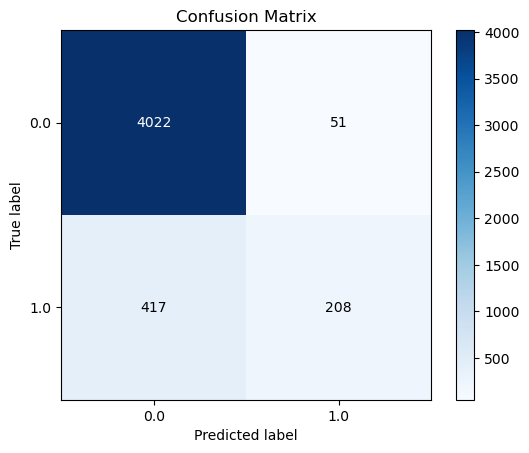

In [29]:
plot_confusion_matrix(y_test, logit.predict(X_test))